# **Khởi tạo**

**Import thư viện**

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape
import os

**Đọc và xử lý dữ liệu**

In [88]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [89]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [90]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [91]:
def CNN_LSTM_prediction(name, data, train_ratio=0.7, days=30):

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    seq_size = 100
    X_train, y_train = create_dataset(train_data, seq_size)
    X_test, y_test = create_dataset(test_data, seq_size)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình CNN-LSTM
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(LSTM(units=20, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Lấy dữ liệu sau timestep
    y_test_adjusted = data[train_size+seq_size:len(y_pred)+train_size+seq_size]

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Dự báo các ngày tiếp theo
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Vẽ hình
    plt.title('CNN-LSTM {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+seq_size+1, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+days-1, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict'+str(days)+'days'])
    plt.show()


# **BIDV**

In [92]:
data = read_file("../Dataset/BID Historical Data.csv");
name = 'BIDV'

## **30 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.1759473970428182
Testing MAE: 0.06282480879731034
Testing MAPE: 20.06228109768596


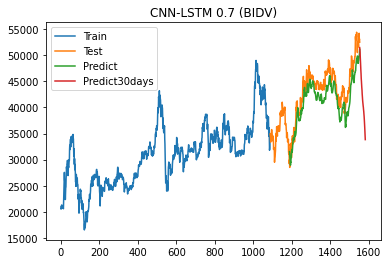

In [93]:
CNN_LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Testing RMSE: 0.1271366379083921
Testing MAE: 0.02883629965332031
Testing MAPE: 13.020629852601001


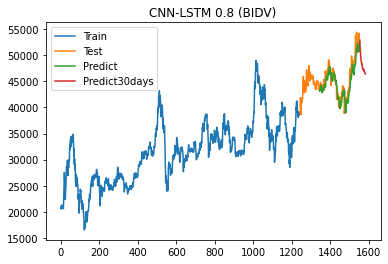

In [94]:
CNN_LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Testing RMSE: 0.1011536305655581
Testing MAE: 0.03269496582516885
Testing MAPE: 9.332349939131287


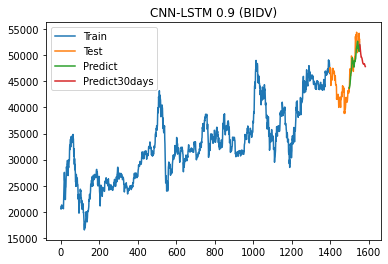

In [95]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.16894050100057137
Testing MAE: 0.041937221033121495
Testing MAPE: 19.48572635445698


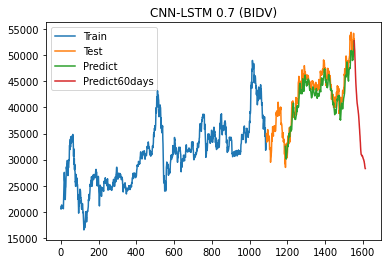

In [96]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.12276343294325646
Testing MAE: 0.03228596637866875
Testing MAPE: 12.52413557158053


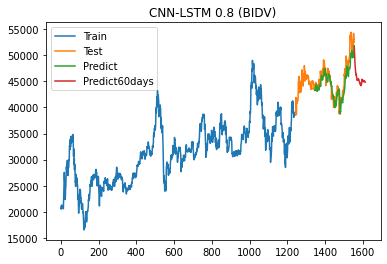

In [97]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Testing RMSE: 0.09915172425361518
Testing MAE: 0.030163875152708942
Testing MAPE: 9.188087674029237


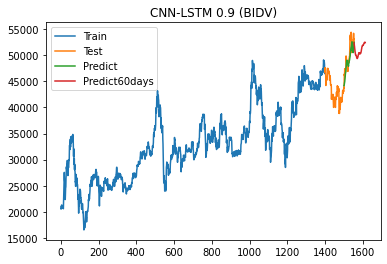

In [98]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.17021119535650653
Testing MAE: 0.037111426409346754
Testing MAPE: 19.564287966476492


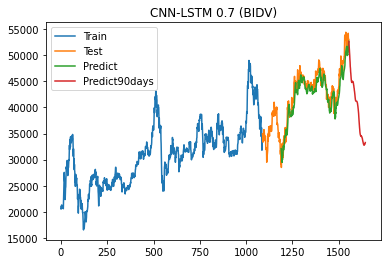

In [99]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.12964659132781284
Testing MAE: 0.07131109277799297
Testing MAPE: 12.524274197345656


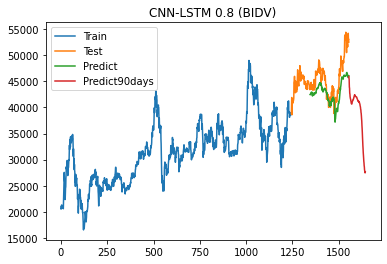

In [100]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.11076719596970397
Testing MAE: 0.04795589322271367
Testing MAPE: 10.073944417719048


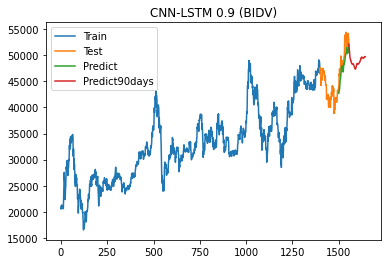

In [101]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **VCB**

In [102]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

## **30 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 0.15478288793442108
Testing MAE: 0.05382814658022459
Testing MAPE: 16.846116296404826


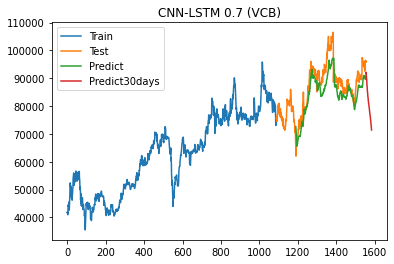

In [103]:
CNN_LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.11226702202630033
Testing MAE: 0.03132579403983222
Testing MAPE: 11.322994078922246


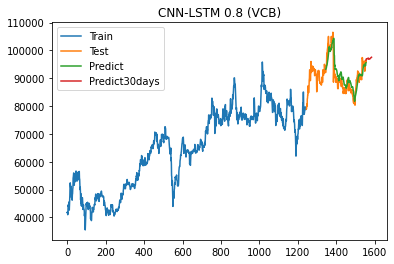

In [104]:
CNN_LSTM_prediction(name, data, 0.8)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 0.06201423436431378
Testing MAE: 0.025369376983138892
Testing MAPE: 6.282306979141807


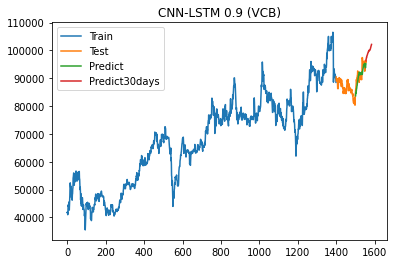

In [105]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.1527365380149825
Testing MAE: 0.04654843331621698
Testing MAPE: 16.581540080781913


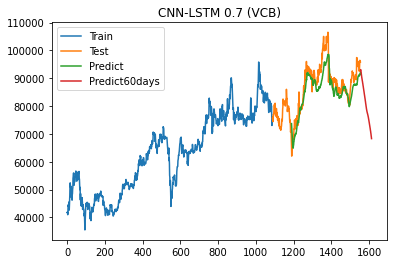

In [106]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 0.10677240509107443
Testing MAE: 0.032919546800013084
Testing MAPE: 10.352081365627479


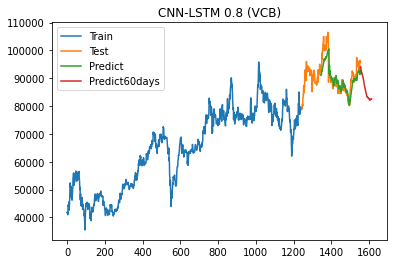

In [107]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 0.06803617570432384
Testing MAE: 0.030677811783043317
Testing MAPE: 7.224671910169196


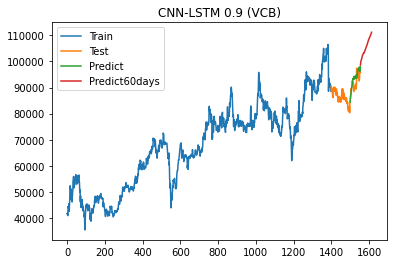

In [108]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 0.1506405651599793
Testing MAE: 0.029613066279685244
Testing MAPE: 16.625279186341842


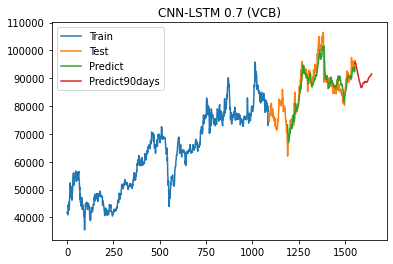

In [109]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.10253437567577373
Testing MAE: 0.03882364724272035
Testing MAPE: 10.297915033359386


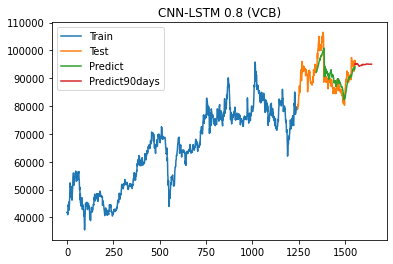

In [110]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 0.06740873190032926
Testing MAE: 0.027315928376474646
Testing MAPE: 6.599833232163868


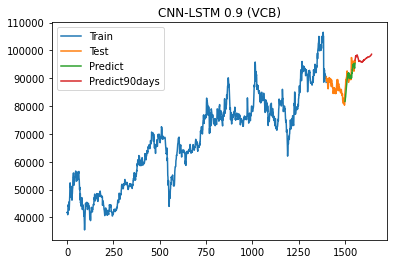

In [111]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **MBB**

In [112]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

## **30 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 0.14695161481668892
Testing MAE: 0.09772615123562203
Testing MAPE: 24.586790090420184


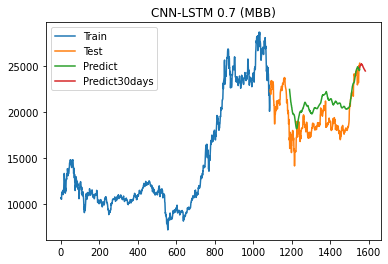

In [113]:
CNN_LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.131691450763786
Testing MAE: 0.023229258850768292
Testing MAPE: 16.577574145708486


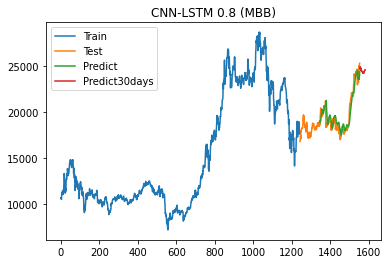

In [114]:
CNN_LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.10317293924423428
Testing MAE: 0.0269114041903052
Testing MAPE: 11.545752325965019


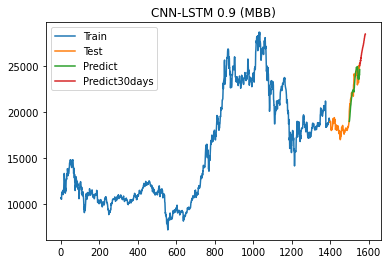

In [115]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 0.14739955085642
Testing MAE: 0.09099800820520544
Testing MAPE: 24.004876968815033


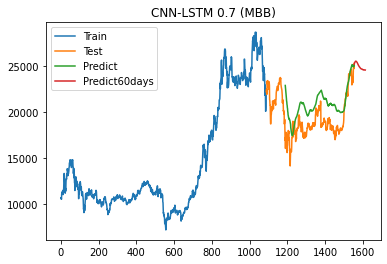

In [116]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.13356857709833364
Testing MAE: 0.029616137444219308
Testing MAPE: 17.268167733436453


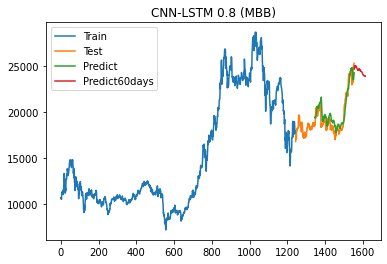

In [117]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.10737147584698617
Testing MAE: 0.03309499859094958
Testing MAPE: 11.87008583940125


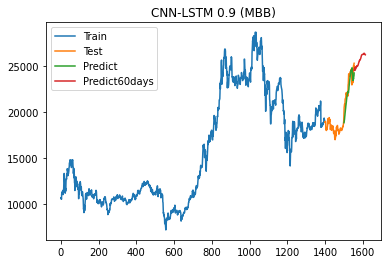

In [118]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Testing RMSE: 0.14684907061432467
Testing MAE: 0.0953491199418905
Testing MAPE: 24.33264115817031


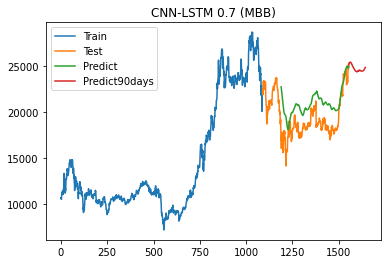

In [119]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.13529510284391352
Testing MAE: 0.02607772446220269
Testing MAPE: 17.32791576384231


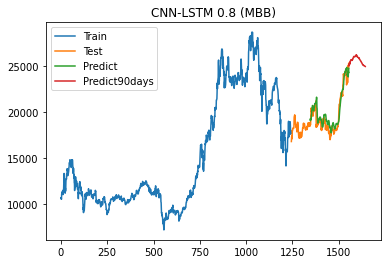

In [120]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 0.10721442541413143
Testing MAE: 0.031543785870130805
Testing MAPE: 11.930061908195459


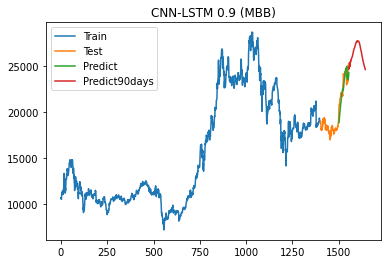

In [121]:
CNN_LSTM_prediction(name, data, 0.9, 90)